<a href="https://colab.research.google.com/github/pireylow/stock-price-prediction-LSTM-ARIMA/blob/main/LSTM_4_Features_HLOC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance

In [2]:
import random
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
import yfinance as yf
yf.pdr_override()

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense

In [3]:
#set stock information
ticker = 'SPY'
startdate = '2018-01-01'
enddate = '2023-01-01'

start = pd.to_datetime(startdate)
end = pd.to_datetime(enddate)
sdata = pdr.get_data_yahoo(ticker, start=start, end=end)

columnsTitles=['Open','High','Low','Close','Volume','Adj Close']
sdata=sdata.reindex(columns=columnsTitles)
#sdata.describe()
#sdata.head()

#HLOC ordering .....
nfeatures = 4
feature_set=sdata.to_numpy()[:,[1,2,0,3]]

out_feature_index = 3  #choose to predict the which one
feature_set.shape


[*********************100%***********************]  1 of 1 completed


(1259, 4)

In [4]:
print(feature_set)

[[268.80999756 267.3999939  267.83999634 268.76998901]
 [270.64001465 268.95999146 268.95999146 270.47000122]
 [272.16000366 270.54000854 271.20001221 271.60998535]
 ...
 [383.39001465 376.42001343 381.32998657 376.66000366]
 [384.3500061  379.07998657 379.63000488 383.44000244]
 [382.57998657 378.42999268 380.64001465 382.42999268]]


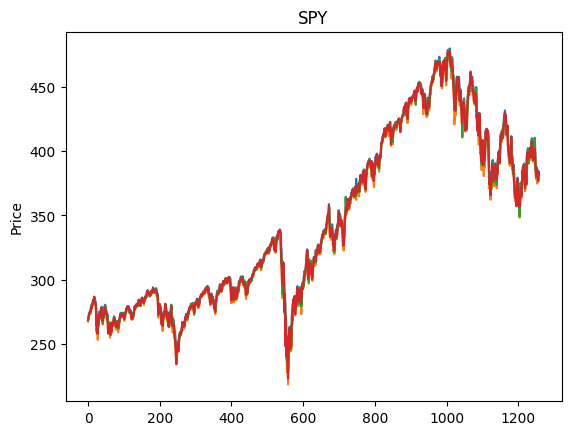

In [5]:
#simple plot for double check of data
plt.title(ticker)
plt.plot(feature_set)
plt.ylabel('Price')
plt.show()

In [6]:
#create price data set
ntrvals = 1200
train_data=feature_set[0:ntrvals,:]
valid_data=feature_set[ntrvals:,:]


In [7]:
#scale the data set
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(feature_set)

yscaler=MinMaxScaler(feature_range=(0,1))
yscaled_data=yscaler.fit_transform(feature_set[:,out_feature_index].reshape(-1,1))

In [8]:
#build the LSTM training set
blocksize=60
x_train_data,y_train_data=[],[]
for i in range(blocksize,len(train_data)):
    x_train_data.append(scaled_data[i-blocksize:i,:])

    #out_feature_index=0 ==> predict H
    #out_feature_index=1 ==> predict L
    #out_feature_index=2 ==> predict O
    #out_feature_index=3 ==> predict C
    y_train_data.append(yscaled_data[i])

x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)
print(x_train_data.shape)
print(y_train_data.shape)

(1140, 60, 4)
(1140, 1)


In [9]:
#build the model
lstm_model=Sequential()
#lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],nfeatures)))
#lstm_model.add(LSTM(units=50))

lstm_model.add(LSTM(units=120,input_shape=(x_train_data.shape[1],nfeatures)))
lstm_model.add(Dense(15))
lstm_model.add(Dense(1))

lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 120)               60000     
                                                                 
 dense (Dense)               (None, 15)                1815      
                                                                 
 dense_1 (Dense)             (None, 1)                 16        
                                                                 
Total params: 61,831
Trainable params: 61,831
Non-trainable params: 0
_________________________________________________________________


In [10]:
lstm_model.fit(x_train_data,y_train_data,epochs=1,batch_size=1,verbose=2)

1140/1140 - 38s - loss: 0.0030 - 38s/epoch - 33ms/step


In [11]:
#test the nfeatures=1 model
inputs_data=scaled_data[feature_set.shape[0]-valid_data.shape[0]-blocksize :,:]
outputs_data=yscaled_data[feature_set.shape[0]-valid_data.shape[0]-blocksize :,:]

X_test=[]
Y_test=[]
for i in range(blocksize,inputs_data.shape[0]):
  X_test.append(inputs_data[i-blocksize:i,:])
  Y_test.append(outputs_data[i,0])
X_test=np.array(X_test)
Y_test=np.array(Y_test)
Y_test=np.reshape(Y_test,(Y_test.shape[0],1))
predicted_price=lstm_model.predict(X_test)
predicted_price=yscaler.inverse_transform(predicted_price)

2/2 [==============================] - 1s 28ms/step


In [12]:
print(predicted_price)

[[373.51392]
 [372.39075]
 [369.8211 ]
 [367.02594]
 [364.4342 ]
 [363.46207]
 [363.23184]
 [364.04608]
 [366.94098]
 [368.4675 ]
 [369.2263 ]
 [370.63333]
 [373.4196 ]
 [377.10165]
 [380.02206]
 [381.57373]
 [383.83643]
 [385.47952]
 [386.59576]
 [385.4271 ]
 [381.88474]
 [380.19638]
 [379.85645]
 [380.64603]
 [379.92612]
 [383.85205]
 [388.52887]
 [391.98517]
 [395.1478 ]
 [396.47598]
 [396.3312 ]
 [396.76382]
 [396.52072]
 [397.43103]
 [398.97562]
 [400.353  ]
 [400.0091 ]
 [399.02756]
 [400.44537]
 [402.79132]
 [404.07446]
 [403.741  ]
 [401.74997]
 [399.4615 ]
 [398.30212]
 [397.1848 ]
 [397.16797]
 [399.4857 ]
 [400.30392]
 [398.213  ]
 [394.28113]
 [390.31937]
 [387.08478]
 [386.26834]
 [384.7479 ]
 [383.82138]
 [383.2982 ]
 [382.314  ]
 [382.56192]]


In [13]:
print(valid_data)

[[373.29000854 360.94000244 368.97000122 362.79000854]
 [364.20999146 357.67001343 363.95999146 360.01998901]
 [363.02999878 355.70999146 358.23999023 357.73999023]
 [359.82000732 356.29998779 358.17001343 356.55999756]
 [367.51000977 348.10998535 349.20999146 365.97000122]
 [370.26000977 356.95999146 368.54998779 357.63000488]
 [367.98001099 357.27999878 364.01000977 366.82000732]
 [375.45001221 367.51998901 375.13000488 371.13000488]
 [371.8500061  365.54998779 368.98999023 368.5       ]
 [372.67001343 364.60998535 368.02999878 365.41000366]
 [374.79998779 363.54000854 365.11999512 374.29000854]
 [380.05999756 373.10998535 375.89001465 378.86999512]
 [385.25       378.67001343 378.79000854 384.92001343]
 [387.57998657 381.3500061  381.61999512 382.01998901]
 [385.         379.32998657 383.07000732 379.98001099]
 [389.51998901 379.67999268 379.86999512 389.01998901]
 [388.3999939  385.26000977 386.44000244 386.20999146]
 [390.39001465 383.29000854 390.14001465 384.51998901]
 [388.6300

In [14]:
print(X_test.shape)
print(predicted_price.shape)
print(valid_data.shape)
print(len(valid_data))


mse0 =  (1/len(valid_data[:,0])) * np.sum((predicted_price[:,0]-valid_data[:,0])*(predicted_price[:,0]-valid_data[:,0]))
mse1 =  (1/len(valid_data[:,1])) * np.sum((predicted_price[:,0]-valid_data[:,1])*(predicted_price[:,0]-valid_data[:,1]))
mse2 =  (1/len(valid_data[:,2])) * np.sum((predicted_price[:,0]-valid_data[:,2])*(predicted_price[:,0]-valid_data[:,2]))
mse3 =  (1/len(valid_data[:,3])) * np.sum((predicted_price[:,0]-valid_data[:,3])*(predicted_price[:,0]-valid_data[:,3]))
print(mse0)
print(mse1)
print(mse2)
print(mse3)


(59, 60, 4)
(59, 1)
(59, 4)
59
45.47542704501331
62.47785946805725
40.55828578269772
52.61985420017361


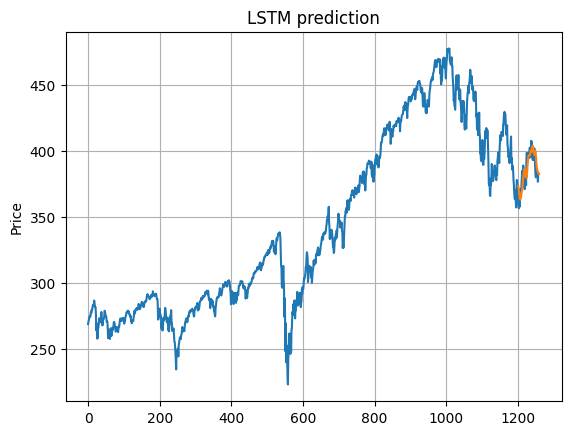

In [15]:
plt.plot(feature_set[:,out_feature_index])
plt.plot(list(range(ntrvals+1,len(feature_set[:,out_feature_index])+1)),list(predicted_price))
plt.ylabel('Price')
plt.title('LSTM prediction')
plt.grid()

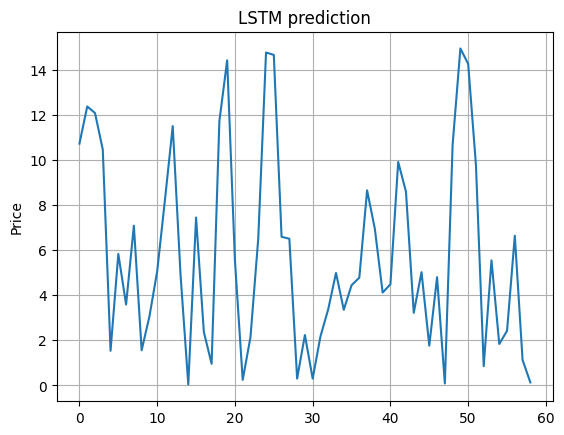

In [16]:

plt.plot(np.abs(predicted_price-valid_data[:,out_feature_index].reshape(-1,1)))
plt.ylabel('Price')
plt.title('LSTM prediction')
plt.grid()